In [1]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
sys.path.insert(0, os.getenv('SRC_PATH'))

import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from src.volsurface import GridInterpVolSurface, KernelVolSurface, VAEPWVolSurface
from src.utils.data_helper import clean_data, VolSurfPointwiseDataset

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from src.train import Trainer

import json

DB_PATH = os.getenv('DB_PATH')
CSV_PATH = os.getenv('CSV_PATH')
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

pd.set_option('future.no_silent_downcasting', True)

from src.utils.logger import setup_logger
logger = setup_logger('train')

/Users/zhanghq/miniconda3/envs/vae-volsurface/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-21 22:58:57,860	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-21 22:58:58,046	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
query = """
SELECT date, symbol, exdate, last_date, cp_flag, strike_price, best_bid, best_offer, volume, open_interest, impl_volatility, delta
FROM opprc
"""
dtype = {
    'symbol': 'string',
    'cp_flag': 'string',
    'strike_price': 'float64',
    'best_bid': 'float64',
    'best_offer': 'float64',
    'volume': 'int64',
    'open_interest': 'int64',
    'impl_volatility': 'float64',
    'delta': 'float64'
}
df_raw = pd.read_sql_query(query, conn, parse_dates=['date', 'exdate', 'last_date'])
df_raw = df_raw.replace('', np.nan) # sqlite returns empty strings for NULL values
df_raw = df_raw.astype(dtype)

df = clean_data(df_raw)

[2025-04-21 22:59:14] [INFO] src.utils.data_helper (50) : Bad data - Filtered 1110238 rows, Retained sample 76.67%
[2025-04-21 22:59:26] [INFO] src.utils.data_helper (63) : Consecutive trading stats completed
[2025-04-21 22:59:28] [INFO] src.utils.data_helper (86) : Consecutive trading - Filtered 2341950 rows, Retained sample 35.81%
[2025-04-21 22:59:28] [INFO] src.utils.data_helper (91) : Moneyness calculation completed


In [4]:
model_name = "vae_pw_ii_beta_1e-2"
train_model = False
load_model = True
save_model = False
data_dir = CSV_PATH + "/predicted_vol_surfaces.json"  # Path to the volatility surfaces dataset
batch_size = 32
epochs = 10

SRC_PATH = os.getenv('SRC_PATH')
os.chdir(SRC_PATH)
trainer = Trainer(model_name)
trainer.create_model()

[2025-04-21 22:59:48] [INFO] src.train (62) : Using device: mps


In [6]:
maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360, 720])
delta_grid = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

with open(data_dir, "r") as f:
    data = json.load(f)

mapping_dict = {dt: i for i, dt in enumerate(sorted(map(lambda x: x[:10], data.keys())))}

df['mapping_ids'] = df['date'].dt.strftime('%Y-%m-%d').map(mapping_dict)

vol_surfaces = []
for key in sorted(data.keys()):
    surface = torch.tensor(data[key], dtype=torch.float32)
    vol_surfaces.append(surface.flatten())  # Flatten 2D to 1D

data_tensor = torch.stack(vol_surfaces)
pw_grid_data = torch.tensor(df[['moneyness', 'ttm']].values, dtype=torch.float32)
pw_vol_data = torch.tensor(df['impl_volatility'].values, dtype=torch.float32)
mapping_ids = torch.tensor(df['mapping_ids'].values).long()

assert data_tensor.shape[0] == max(mapping_ids) + 1

dataset = VolSurfPointwiseDataset(pw_grid_data, pw_vol_data, data_tensor, mapping_ids)
train_loader = DataLoader(
    dataset, 
    batch_size=trainer.batch_size,
    shuffle=True
)

In [8]:
trainer.beta = 1e-2

In [10]:
# Train the model
for epoch in range(epochs):
    logger.info(f"Epoch {epoch + 1}/{epochs}")
    trainer.train(train_loader)

[2025-04-21 23:03:07] [INFO] train (3) : Epoch 1/10
[2025-04-21 23:04:24] [INFO] src.train (181) : Loss: 0.0058
[2025-04-21 23:04:24] [INFO] train (3) : Epoch 2/10
[2025-04-21 23:05:41] [INFO] src.train (181) : Loss: 0.0041
[2025-04-21 23:05:41] [INFO] train (3) : Epoch 3/10
[2025-04-21 23:06:57] [INFO] src.train (181) : Loss: 0.0039
[2025-04-21 23:06:57] [INFO] train (3) : Epoch 4/10
[2025-04-21 23:08:14] [INFO] src.train (181) : Loss: 0.0038
[2025-04-21 23:08:14] [INFO] train (3) : Epoch 5/10
[2025-04-21 23:09:31] [INFO] src.train (181) : Loss: 0.0037
[2025-04-21 23:09:31] [INFO] train (3) : Epoch 6/10
[2025-04-21 23:10:48] [INFO] src.train (181) : Loss: 0.0037
[2025-04-21 23:10:48] [INFO] train (3) : Epoch 7/10
[2025-04-21 23:12:06] [INFO] src.train (181) : Loss: 0.0036
[2025-04-21 23:12:06] [INFO] train (3) : Epoch 8/10
[2025-04-21 23:13:24] [INFO] src.train (181) : Loss: 0.0036
[2025-04-21 23:13:24] [INFO] train (3) : Epoch 9/10
[2025-04-21 23:14:42] [INFO] src.train (181) : Loss:

In [12]:
torch.save(trainer.model.state_dict(), f"params/{trainer.model_name}.pth")

In [13]:
trainer.model.eval()
data_tensor = data_tensor.to(trainer.device)
encoder_outputs_mean = []
encoder_outputs_logvar = []
with torch.no_grad(): 
    for input_data in data_tensor:
        encoder_output = trainer.model.encoder(input_data.unsqueeze(0))
        encoder_outputs_mean.append(encoder_output[0])
        encoder_outputs_logvar.append(encoder_output[1])
encoder_outputs_mean = torch.cat(encoder_outputs_mean, dim=0)
encoder_outputs_logvar = torch.cat(encoder_outputs_logvar, dim=0)

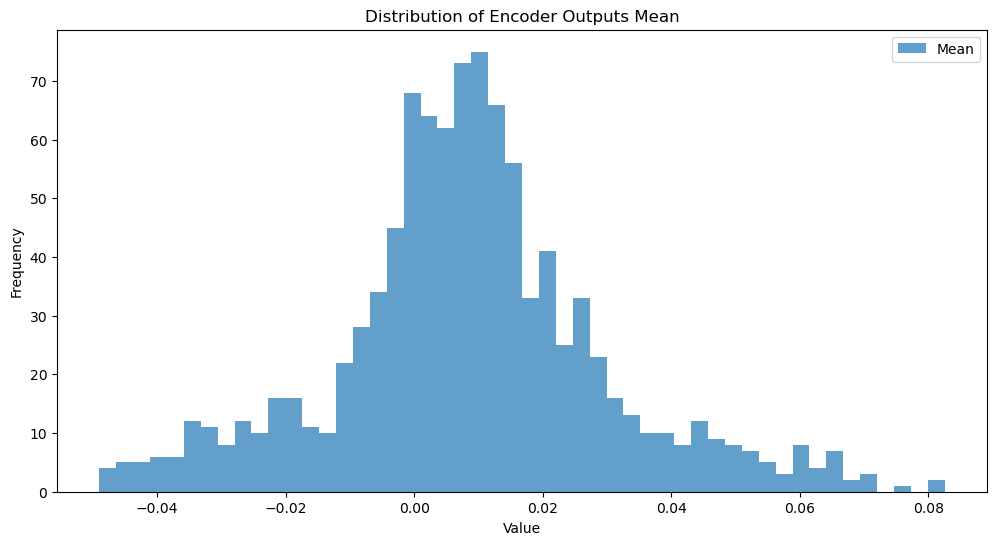

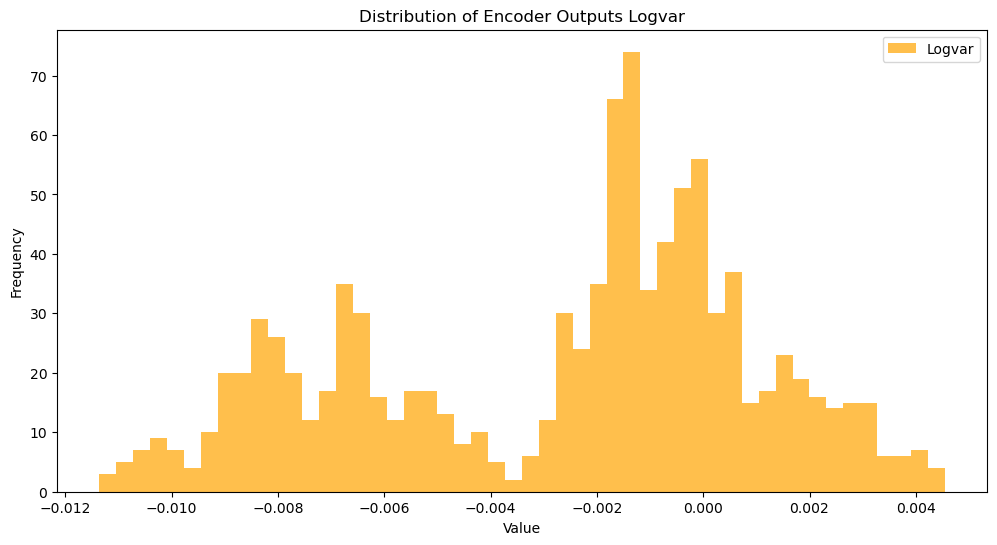

In [14]:
import matplotlib.pyplot as plt

# Plot the distribution of mean
plt.figure(figsize=(12, 6))
plt.hist(encoder_outputs_mean.cpu().numpy().flatten(), bins=50, alpha=0.7, label='Mean')
plt.title('Distribution of Encoder Outputs Mean')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot the distribution of logvar
plt.figure(figsize=(12, 6))
plt.hist(encoder_outputs_logvar.cpu().numpy().flatten(), bins=50, alpha=0.7, label='Logvar', color='orange')
plt.title('Distribution of Encoder Outputs Logvar')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

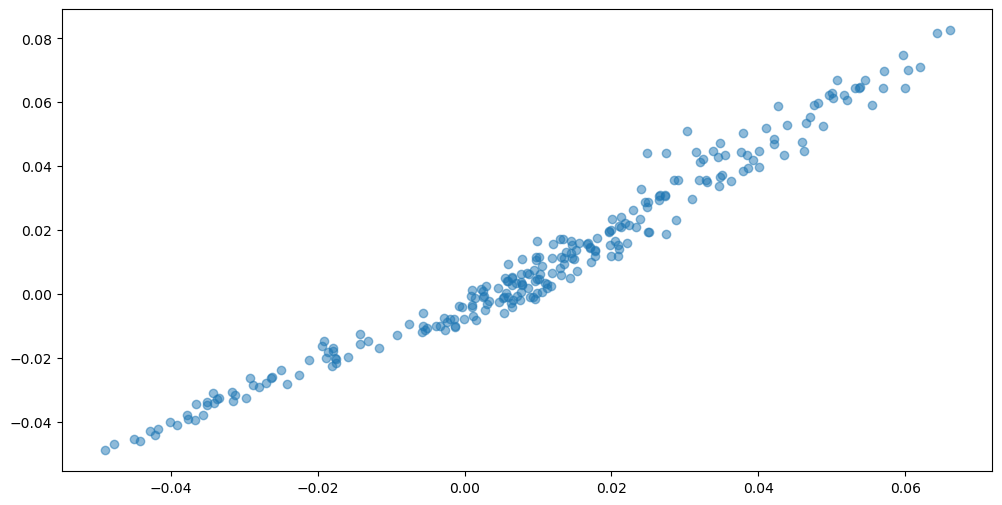

In [18]:
encoder_outputs_mean_ = encoder_outputs_mean.cpu().numpy()
# compute variance for encoder outputs mean
encoder_outputs_mean_var = np.var(encoder_outputs_mean_, axis=0)
# get the indices of the largest 2 var
indices = np.argsort(encoder_outputs_mean_var)[-2:]
encoder_outputs_mean_ = encoder_outputs_mean_[:, indices]
# plot
plt.figure(figsize=(12, 6))
plt.scatter(encoder_outputs_mean_[:, 0], encoder_outputs_mean_[:, 1], alpha=0.5)

In [16]:
vix_data  = pd.read_csv(CSV_PATH + "/VIX_HISTORY.csv",parse_dates=['DATE'])
vix_data['DATE'] = pd.to_datetime(vix_data['DATE'])
vix_data = vix_data.set_index('DATE')
vix_close = vix_data.loc[df.date.unique()]['CLOSE'].values

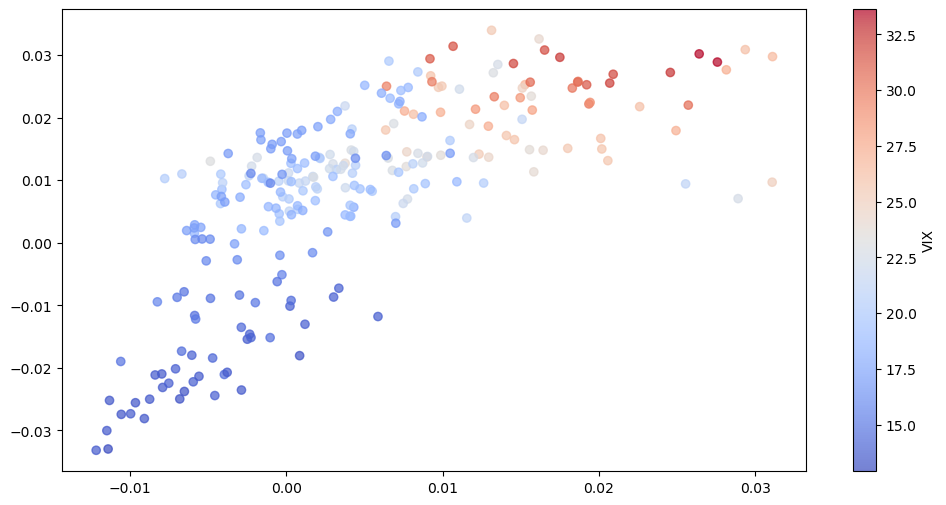

In [17]:
vix_close_scale = (vix_close - np.mean(vix_close)) / np.std(vix_close)
encoder_outputs_mean_ = encoder_outputs_mean.cpu().numpy()
# compute variance for encoder outputs mean
encoder_outputs_mean_var = np.var(encoder_outputs_mean_, axis=0)
# get the indices of the largest 2 var
indices = np.argsort(encoder_outputs_mean_var)[:]
encoder_outputs_mean_ = encoder_outputs_mean_[:, indices]
# plot
plt.figure(figsize=(12, 6))
ld = plt.scatter(encoder_outputs_mean_[:, 0], encoder_outputs_mean_[:, 1], alpha=0.7, c = vix_close, cmap='coolwarm')
plt.colorbar(ld, label="VIX")

In [20]:
from src.volsurface import VAEPWVolSurface

In [21]:
vaepw_surface = VAEPWVolSurface(trainer.model)

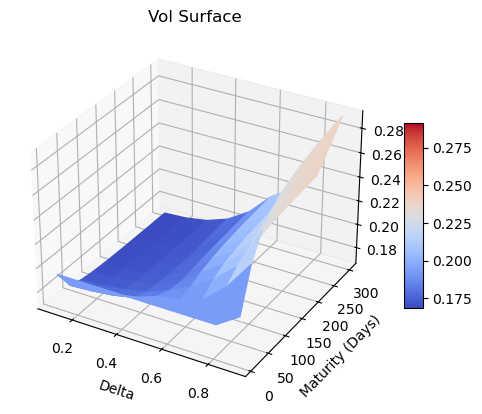

In [140]:
vaepw_surface.plot(maturity_range=(7, 300))
vaepw_surface.refresh()

Explained Variance Ratio: [0.8231642  0.10973942 0.03707075 0.00925958]


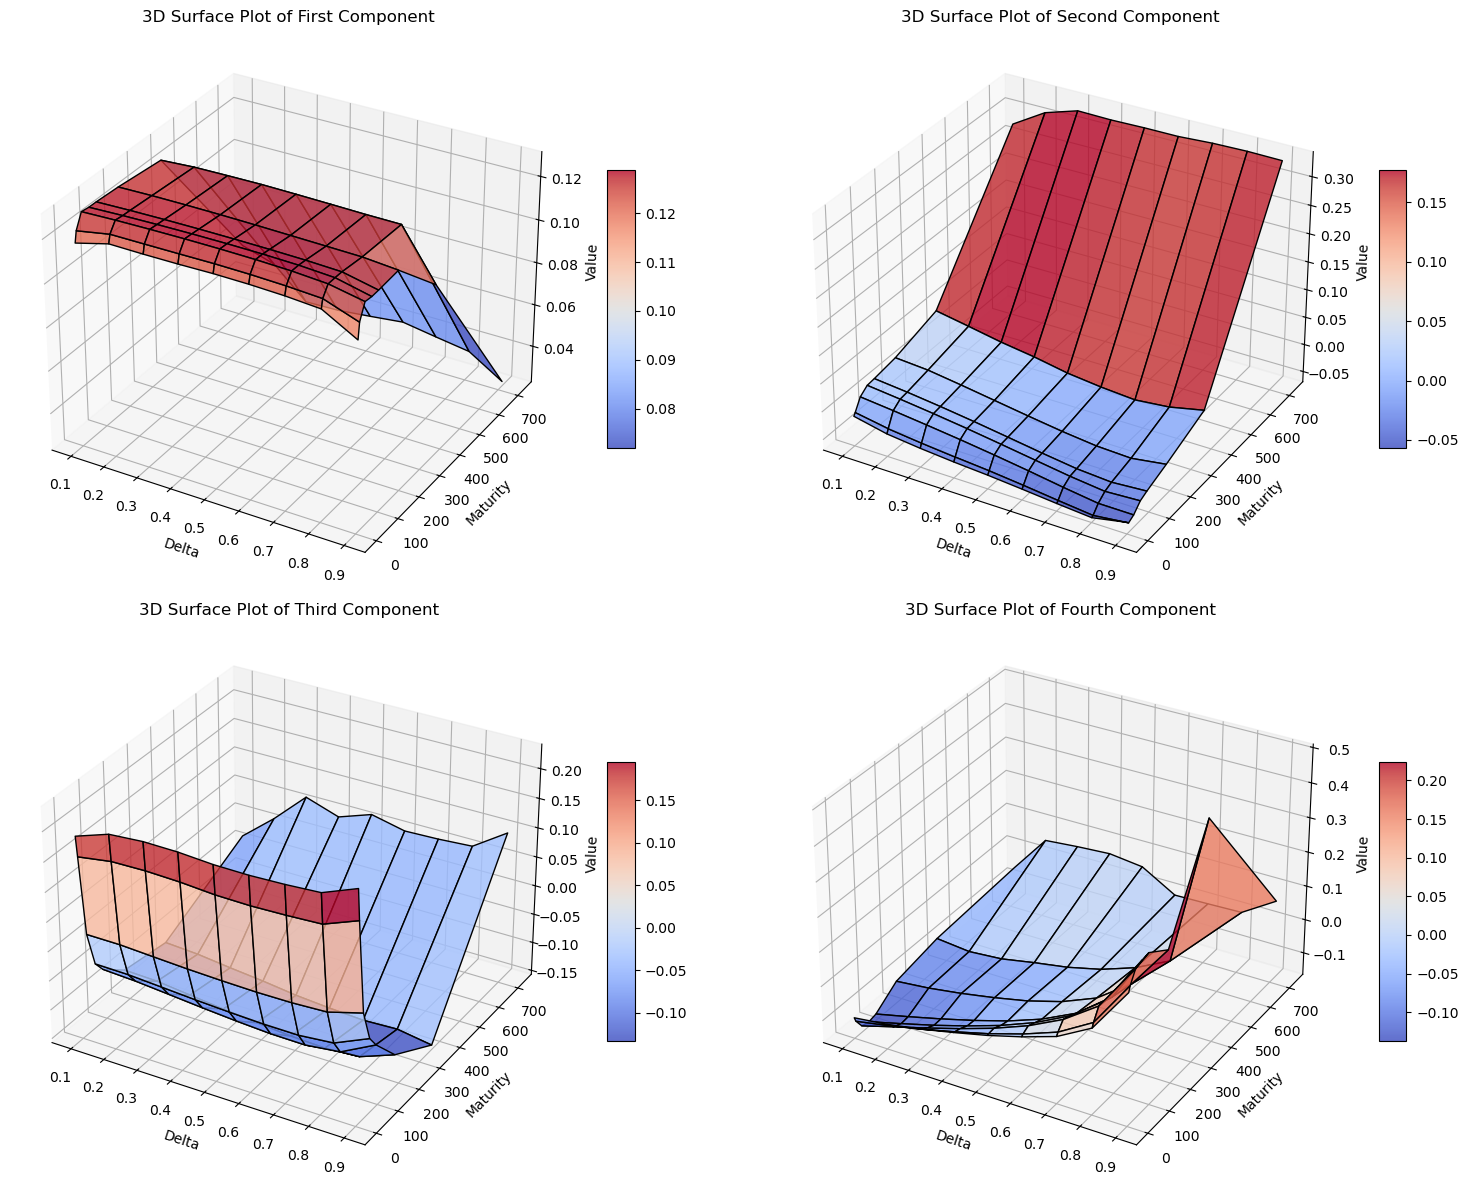

In [153]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# Flatten the vol_surfaces tensors and convert them to a numpy array
vol_surfaces_flat = np.array([surface.cpu().numpy().flatten() for surface in vol_surfaces])

# Standardize the data
scaler = StandardScaler()
vol_surfaces_scaled = scaler.fit_transform(vol_surfaces_flat)

# Fit PCA with 4 components
pca = PCA(n_components=4)
vol_surfaces_pca = pca.fit_transform(vol_surfaces_scaled)

# Get the explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

# Reshape the first 4 components back to the delta and maturity grids
components = pca.components_
reshaped_components = [component.reshape(len(delta_grid), len(maturity_grid)) for component in components]

# 4 Subplots for each principal component

fig, axes = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': '3d'})
components_titles = ["First Component", "Second Component", "Third Component", "Fourth Component"]

for i, ax in enumerate(axes.flat):
    X, Y = np.meshgrid(delta_grid, maturity_grid, indexing='ij')
    Z = reshaped_components[i]  # Principal component i
    surf = ax.plot_surface(X, Y, Z, cmap="coolwarm", edgecolor='k', alpha=0.8)
    ax.set_title(f"3D Surface Plot of {components_titles[i]}")
    ax.set_xlabel("Delta")
    ax.set_ylabel("Maturity")
    ax.set_zlabel("Value")
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()

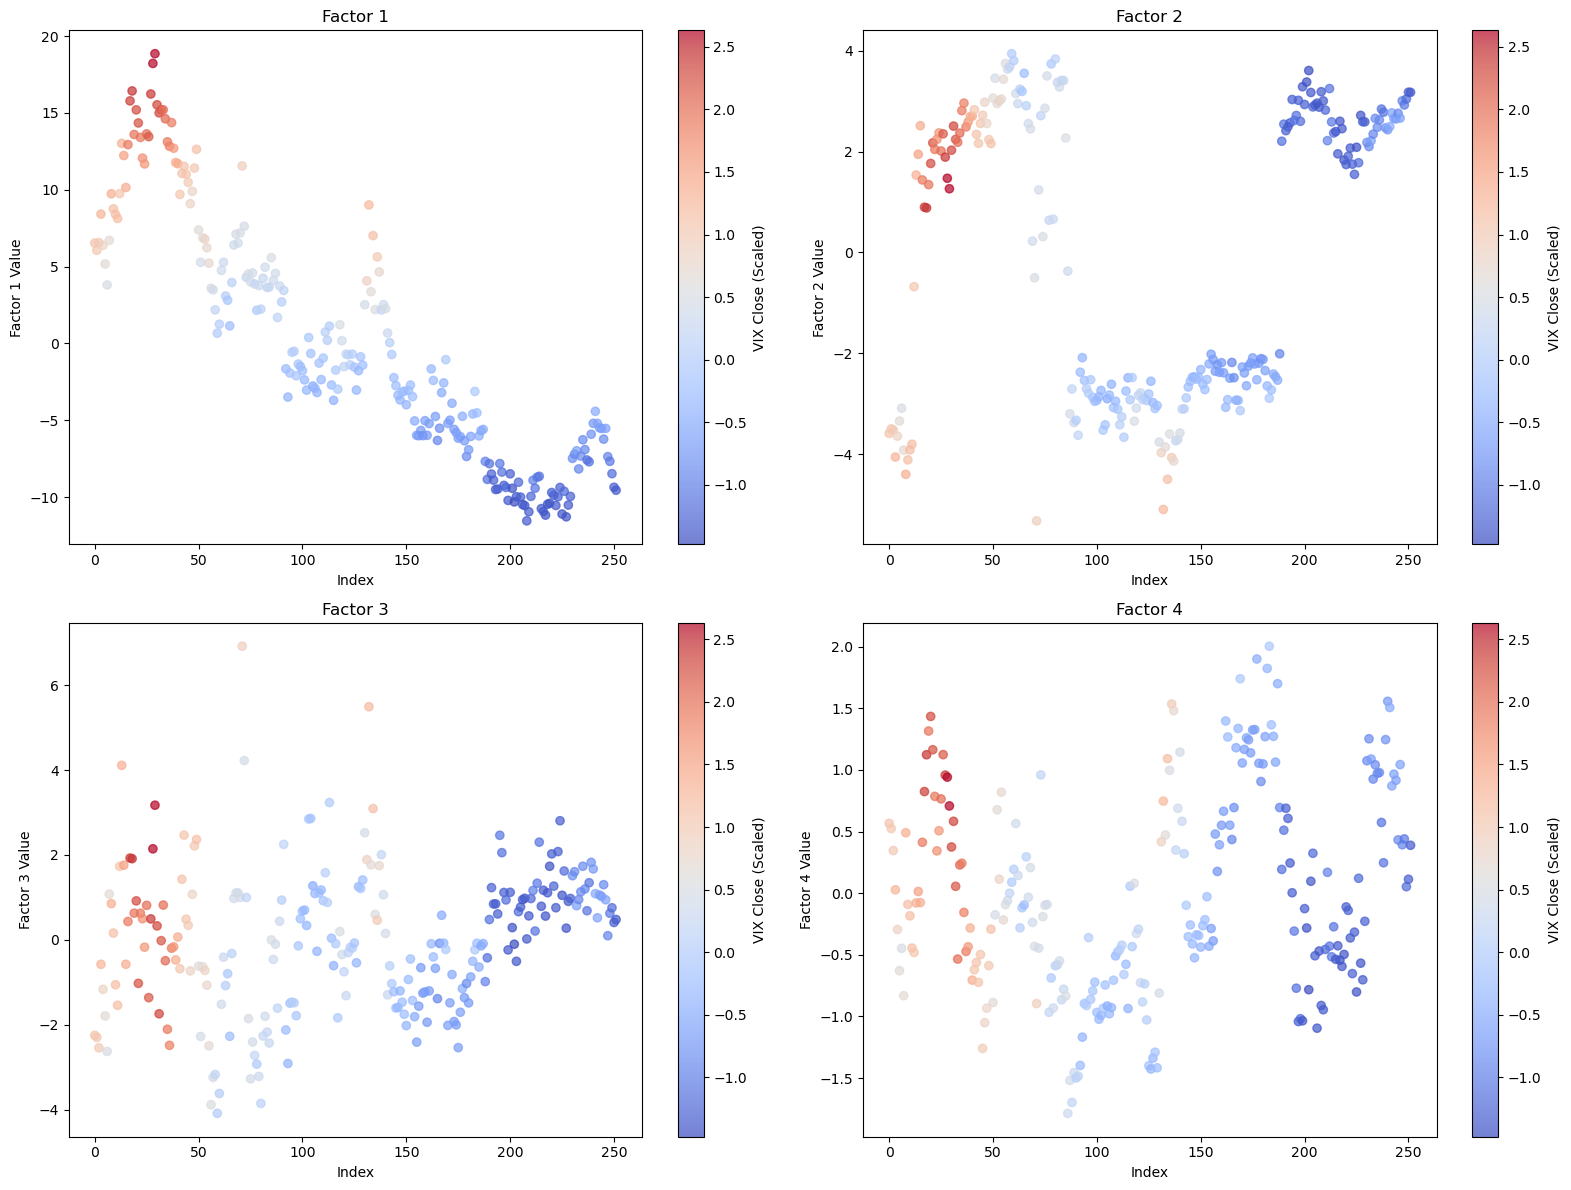

In [158]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, ax in enumerate(axes.flat):
    scatter = ax.scatter(
        range(len(vol_surfaces_pca[:, i])),
        vol_surfaces_pca[:, i],
        c=vix_close_scale,
        cmap='coolwarm',
        alpha=0.7
    )
    ax.set_title(f"Factor {i + 1}")
    ax.set_xlabel("Index")
    ax.set_ylabel(f"Factor {i + 1} Value")
    fig.colorbar(scatter, ax=ax, label="VIX Close (Scaled)")

plt.tight_layout()
plt.show()